In [1]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from functorch import make_functional,hessian

In [36]:
def get_one_hessian_zero(model,criterion,x,y):
    x = x.to(device)
    y = y.to(device)
    if x.dim() == 1:
        x = x.unsqueeze(0)
    if y.dim() == 0:
        y = y.unsqueeze(0)
    model.zero_grad()
    fnet, params = make_functional(model)
    params = [p.detach().requires_grad_() for p in params]
    
    def loss_fun(params):
        output = fnet(params, x)
        return criterion(output, y)
    
    nested_hessian = hessian(loss_fun, argnums=0)(params)
    H = flatten_nested_hessian(nested_hessian, params)
    
    return H

def flatten_nested_hessian(nested_hessian, params):
    param_sizes = [p.numel() for p in params]
    total_params = sum(param_sizes)
    flat_hessian = torch.zeros(total_params, total_params)

    row_start = 0
    for i, row in enumerate(nested_hessian):
        row_size = param_sizes[i]
        col_start = 0
        for j, block in enumerate(row):
            block = block.reshape(row_size, param_sizes[j])
            flat_hessian[row_start:row_start+row_size, col_start:col_start+param_sizes[j]] = block
            col_start += param_sizes[j]
        row_start += row_size
    return flat_hessian

def get_loss_grad_zero(model,criterion,x,y):
    x = x.to(device)
    y = y.to(device)
    if x.dim() == 1:
        x = x.unsqueeze(0)
    if y.dim() == 0:
        y = y.unsqueeze(0)
    model.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    params = [p for p in model.parameters() if p.requires_grad]
    grads = torch.autograd.grad(loss, params)
    grad_vector = torch.cat([g.contiguous().view(-1) for g in grads])

    return grad_vector


def hessian_vector_product(model, criterion, x, y, v):
    x = x.to(device)
    y = y.to(device)
    if x.dim() == 1:
        x = x.unsqueeze(0)
    if y.dim() == 0:
        y = y.unsqueeze(0)

    model.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    grad_vector_product = sum(torch.sum(g * v_i) for g, v_i in zip(grads, v))
    hvp = torch.autograd.grad(grad_vector_product, model.parameters())
    
    return torch.cat([h.flatten() for h in hvp])


In [ ]:
num_classes = 10
input_dim = 784
max_lbfgs_iter = 30
train_num = 10000
test_number = 50

device = torch.device("cuda:1")

# Random dataset
X = torch.randn(train_num, input_dim).to(device)
Y = torch.randint(0, num_classes, size=(train_num,)).to(device)

X_test = torch.randn(test_number, input_dim).to(device)
Y_test = torch.randint(0, num_classes, size=(test_number,)).to(device)

In [57]:
# Set and train model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes, bias=False)  

    def forward(self, x):
        return self.linear(x)

model = LogisticRegression(input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(model.parameters(), max_iter=max_lbfgs_iter)

def closure():
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, Y)
    loss.backward()
    return loss

optimizer.step(closure)

# Get z_test_x
test_idx = 8
z_test_x, z_test_y = X_test[test_idx],Y_test[test_idx]
z_test_x, z_test_y = z_test_x.unsqueeze(0), z_test_y.unsqueeze(0)
output = model(z_test_x)
original_loss = criterion(output, z_test_y)
v = get_loss_grad_zero(model, criterion, z_test_x, z_test_y).detach()

In [ ]:
# Get H_theta
batch_size = 1000
param_size = sum(p.numel() for p in model.parameters())

print(f"Computing full Hessian matrix of size {param_size}x{param_size}...")
full_hessian = torch.zeros((param_size, param_size))

for i in range(0, train_num, batch_size):
    end_idx = min(i + batch_size, train_num)
    batch_hessian = torch.zeros_like(full_hessian)
    
    for j in range(i, end_idx):
        x, y = X[j],Y[j]
        sample_hessian = get_one_hessian_zero(model,criterion,x,y)
        batch_hessian += sample_hessian
        del sample_hessian
        torch.cuda.empty_cache()
        
    full_hessian += batch_hessian
    print(i)



In [59]:
# Use CG estimate inverse HVP

hessian_theta = full_hessian / train_num
hessian_theta = hessian_theta.to(device)

def conjugate_gradients(hvp_fn, b, max_iter=100, tol=1e-8):
    x = torch.zeros_like(b).to(device)

    r = b - hvp_fn(x)
    p = r.clone()
    r_norm_sq = torch.dot(r, r)
    
    for i in range(max_iter):
        Ap = hvp_fn(p)
        alpha = r_norm_sq / torch.dot(p, Ap)
        x = x + alpha * p
        
        r = r - alpha * Ap
        new_r_norm_sq = torch.dot(r, r)
        
        if torch.sqrt(new_r_norm_sq) < tol:
            break
            
        beta = new_r_norm_sq / r_norm_sq
        p = r + beta * p
        r_norm_sq = new_r_norm_sq
    
    
    return x

def hvp_fn(v):
    return torch.mv(hessian_theta, v)

inverse_hvp_cg = conjugate_gradients(hvp_fn, v)


# Get top 30 train data points with biggest influence
influences_cg = []
for idx in range(train_num):
    train_x,train_y =  X[idx],Y[idx]
    train_x,train_y = train_x.unsqueeze(0),train_y.unsqueeze(0)
    train_grad = get_loss_grad_zero(model,criterion,train_x,train_y)
    influence = -torch.dot(train_grad, inverse_hvp_cg).item()/train_num
    influences_cg.append(influence)


top_30_indices = np.argsort(-np.abs(np.array(influences_cg)))[:30]
indices_to_remove = top_30_indices.tolist()

influences_cg_30 = []
for idx in indices_to_remove:
    influences_cg_30.append(influences_cg[idx])


In [60]:
# Get real loss loss difference
def loss_without_one(remove_idx):
    X_new = torch.cat([X[:remove_idx], X[remove_idx+1:]], dim=0)
    Y_new = torch.cat([Y[:remove_idx], Y[remove_idx+1:]], dim=0)

    model_remove_one = LogisticRegression(input_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_remove_one = optim.LBFGS(model_remove_one.parameters(), max_iter=max_lbfgs_iter)


    def closure():
        optimizer_remove_one.zero_grad()
        output = model_remove_one(X_new)
        loss = criterion(output, Y_new)
        loss.backward()
        return loss

    optimizer_remove_one.step(closure)
    output = model_remove_one(z_test_x)
    return criterion(output, z_test_y)

real_loss_30 = []
for idx in indices_to_remove:
    after_loss = loss_without_one(idx)
    real_loss_30.append((original_loss - after_loss).item())

In [ ]:
# Use stochastic estimate inverse HVP

def inverse_hvp_stochastic(model, criterion, X, Y, v, damping, recursion_depth, num_samples,scale):
    inverse_hvp = torch.zeros_like(v)
    
    for n in range(num_samples):
        print(f'{n} iterations')
        cur_estimate = v.clone()
        # indices = np.random.choice(train_num, recursion_depth, replace=False)
        indices = [i for i in range(n*recursion_depth,(n+1)*recursion_depth)]
        for i in indices:
            x_sample, y_sample = X[i], Y[i]
            hvp = hessian_vector_product(model, criterion, x_sample, y_sample, cur_estimate)
            cur_estimate = (v + (1 - damping) * cur_estimate - hvp/scale).detach()
        inverse_hvp += cur_estimate/scale
    inverse_hvp /= num_samples
    
    return inverse_hvp

inverse_hvp_se = inverse_hvp_stochastic(model, criterion, X, Y, v, damping=0,recursion_depth=2000, num_samples=4,scale=150)

influences_se_30 = []
for idx in indices_to_remove:
    train_x,train_y = X[idx],Y[idx]
    train_x,train_y = train_x.unsqueeze(0),train_y.unsqueeze(0)
    train_grad = get_loss_grad_zero(model,criterion,train_x,train_y)
    influence = -torch.dot(train_grad, inverse_hvp_se).item()/train_num
    influences_se_30.append(influence)


Text(0.5, 1.0, 'Linear (SE)')

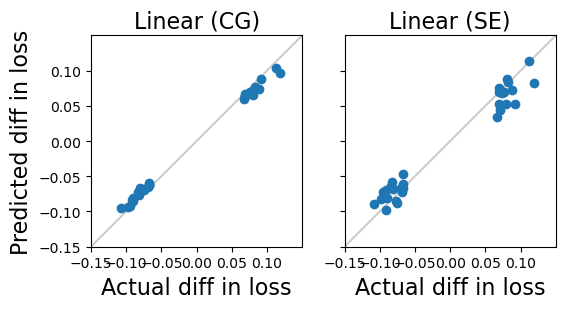

In [ ]:
# Plot

fontsize=16
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6, 3))

for ax in axs: 
    ax.set_aspect('equal')
    ax.set_xlabel('Actual diff in loss', fontsize=fontsize)
    ax.set_xticks(np.arange(-0.15, 0.15, 0.05))
    ax.set_yticks(np.arange(-0.15, 0.15, 0.05))
    ax.set_xlim([-0.15, 0.15])
    ax.set_ylim([-0.15, 0.15])
    ax.plot([-0.15, 0.15], [-0.15, 0.15], 'k-', alpha=0.2, zorder=1)
axs[0].set_ylabel('Predicted diff in loss', fontsize=fontsize)

axs[0].scatter(real_loss_30, influences_cg_30, zorder=2)
axs[0].set_title('Linear (CG)', fontsize=fontsize)
axs[1].scatter(real_loss_30, influences_se_30, zorder=2)
axs[1].set_title('Linear (SE)', fontsize=fontsize)